<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/02_Production_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

In [2]:
!pip install -Uqq fastbook fastai==2.2.5
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 460kB 7.5MB/s 
ERROR: voila 0.2.7 has requirement nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.


In [3]:
import shutil
from fastbook import *
from fastai.vision.widgets import *

Instead of searching in Bing, we will search in Duck Duck Go with the package jmd_imagescraper

https://forums.fast.ai/t/bing-account-expired-what-other-option/76856/15

In [4]:
!pip install -q jmd_imagescraper
from pathlib import Path
from jmd_imagescraper.core import *

In [5]:
#Define classes
pet_types = "cat", "dog"
path = Path().cwd()/"pets"

In [6]:
#Eliminate the directory if exists, if not search images
if path.exists():
    shutil.rmtree(path)

if not path.exists():
    path.mkdir()
    for o in pet_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = duckduckgo_search(path, o, o, max_results=100)

Duckduckgo search: cat


Duckduckgo search: dog


In [7]:
fns = get_image_files(path)
fns

(#200) [Path('/content/pets/cat/005_41768955.jpg'),Path('/content/pets/cat/021_0328f3b8.jpg'),Path('/content/pets/cat/049_78ddc068.jpg'),Path('/content/pets/cat/070_179f40d4.jpg'),Path('/content/pets/cat/067_c4bcb70e.jpg'),Path('/content/pets/cat/077_71e4fe17.jpg'),Path('/content/pets/cat/095_cc33e964.jpg'),Path('/content/pets/cat/030_22ff39b6.jpg'),Path('/content/pets/cat/006_e223e1dd.jpg'),Path('/content/pets/cat/065_69beac8d.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
#Create DataBlock and DataLoaders
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)

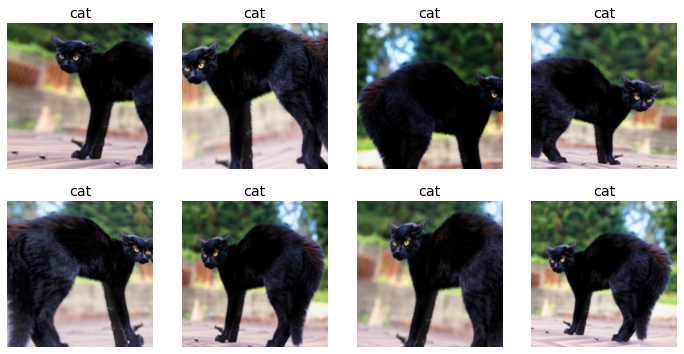

In [11]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.493642,0.628508,0.275000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.522917,0.157037,0.075000,00:01
1,0.417955,0.023750,0.000000,00:01
2,0.295835,0.009710,0.000000,00:01
3,0.226197,0.006963,0.000000,00:01


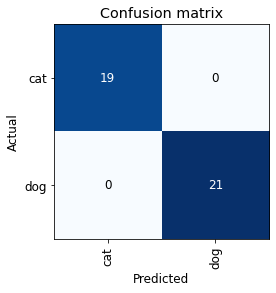

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

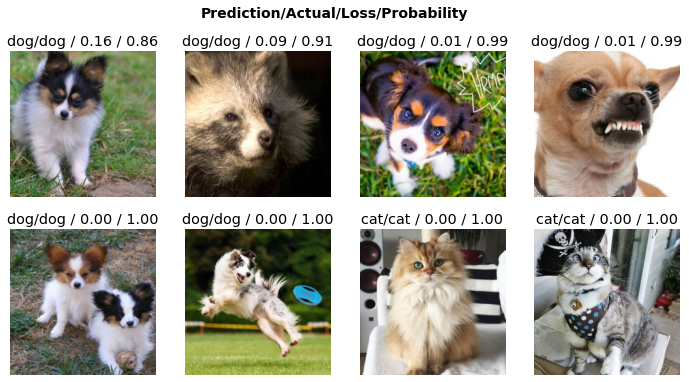

In [14]:
interp.plot_top_losses(8, nrows=2)

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [16]:
learn.export()

In [19]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [24]:
img = PILImage.create(btn_upload.data[-1])

In [25]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [26]:
pred,pred_idx,probs = learn.predict(img)
pred

'cat'

In [27]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: cat; Probability: 1.0000')

In [28]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [29]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[0])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [30]:
VBox([widgets.Label('Select your pet!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [31]:
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 